# Recommendation system for restaurants
### Based on the [Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset).  

## 0. Libraries
First of all, we define all the libraries we need.

In [1]:
from matplotlib.ticker import PercentFormatter as _PercentFormatter
import matplotlib.pyplot as _plt 
import numpy as _np
import pandas as _pd
import joblib as _jl
import glob as _glob
import os as _os

Since we are going to use big datasets, and we'll need to load them more
times, we define a commodity function that deletes all user defined variables,
in order to free some memory.

In [2]:
def _del_all():
    %reset_selective -f [^_]

## 1. Data cleaning
### Based on [Ashish Gandhe's kernel](https://www.kaggle.com/wenqihou828/recommendation-for-yelp-users-itself).

We execute the code in ```recommendation_system_preprocessing.ipynb``` in order to
clean the data and to reduce the size of the dataset, using pickles instead of json and dropping unnecessary columns.

We explore the resulting datasets: 

In [5]:
dataset_list = _glob.glob("../dataset/[!checked]*.pickle")
for d in dataset_list:
    dataset = _pd.read_pickle(d)
    
    f = _os.path.splitext(_os.path.basename(d))[0]
    c = ", ".join(list(dataset.columns))
    s = dataset.shape
    
    print("Dataset '" + f + "':")
    print("\tfeatures:", c)
    print("\tshape:", s)
    print()

Dataset 'all_checkin':
	features: business_id, date
	shape: (57402, 2)

Dataset 'all_review':
	features: review_id, user_id, business_id, stars, useful, funny, cool, text, date
	shape: (4201684, 9)

Dataset 'all_tips':
	features: restaurant_name, tips_date, user_id
	shape: (770878, 3)

Dataset 'all_users':
	features: user_id, user_name, average_stars, yelping_since, review, years_of_elite, fans, useful, cool, funny, friends
	shape: (1148098, 11)

Dataset 'restaurants':
	features: name, business_id, address, cuisine, postal_code, latitude, longitude, review_count, stars, OutdoorSeating, BusinessAcceptsCreditCards, RestaurantsDelivery, RestaurantsReservations, WiFi, Alcohol, categories, city, Monday_Open, Tuesday_Open, Wednesday_Open, Thursday_Open, Friday_Open, Saturday_Open, Sunday_Open, Monday_Close, Tuesday_Close, Wednesday_Close, Thursday_Close, Friday_Close, Saturday_Close, Sunday_Close
	shape: (59371, 31)



In [10]:
_del_all()

## 2. Fake Review Detection
### Based on Zhiwei Zhang's [work](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781) and [code](https://github.com/zzhang83/Yelp_Sentiment_Analysis).

Then, in order to filter out deceptive reviews, that could alter the results
of our analysis, we load the model based on Support Vector Machine
defined in ```Yelp_sentiment_analysis/Scripts/fake_reviews.ipynb```
by [Zhiwei Zhang](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781),
that has the best scores for accuracy, precision, recall and f1-score.

In [2]:
vectorizer = _jl.load('../models/tfidf_vectorizer.joblib')
svc = _jl.load('../models/fake_review_svc_model.joblib')

Now, we can apply this model to our data.

In [4]:
review = _pd.read_pickle("../dataset/all_review.pickle")

review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,I'll be the first to admit that I was not exci...,2013-01-20 13:25:59
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,Tracy dessert had a big name in Hong Kong and ...,2016-05-07 01:21:02
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,This place has gone down hill. Clearly they h...,2010-10-05 19:12:35
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,"Like walking back in time, every Saturday morn...",2011-11-30 02:11:15


In [5]:
texts = list(review["text"])
X = vectorizer.transform(texts)
predictions = svc.predict(X)

In [6]:
print(type(predictions))
print("SVC predictions:", predictions)

<class 'numpy.ndarray'>
SVC predictions: [1 1 1 ... 1 1 1]


Now we repeat the whole process with a different model that allows us to
obtain real weights instead of a binary evaluation. 

In [7]:
cal_svc = _jl.load('../models/fake_review_cal_svc_model.joblib')
cal_predictions = cal_svc.predict_proba(X)


In [8]:
print("Calibrated SVC predictions:\n", cal_predictions)
cal_predictions = _np.array([x[1] for x in cal_predictions])
print("Calibrated SVC predictions for class '1':\n", cal_predictions)

Calibrated SVC predictions:
 [[0.12112422 0.87887578]
 [0.011      0.989     ]
 [0.03538102 0.96461898]
 ...
 [0.36147536 0.63852464]
 [0.00379598 0.99620402]
 [0.00133685 0.99866315]]
Calibrated SVC predictions for class '1':
 [0.87887578 0.989      0.96461898 ... 0.63852464 0.99620402 0.99866315]


In [9]:
print("columns before:\n", review.columns)
checked_review = review.assign(bin_truth_score=predictions, real_truth_score=cal_predictions)
print("columns after:\n", checked_review.columns)

columns before:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
columns after:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


Let's see what we just obtained.

In [10]:
checked_review[['review_id', 'text', 'bin_truth_score', 'real_truth_score']].head()

,review_id,text,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill. Clearly they h...,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,"Like walking back in time, every Saturday morn...",1,0.975404


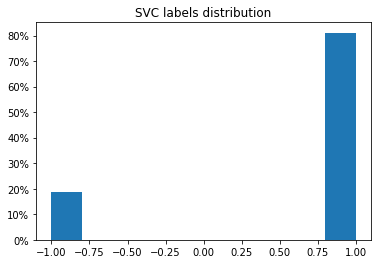

In [11]:
data = checked_review['bin_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

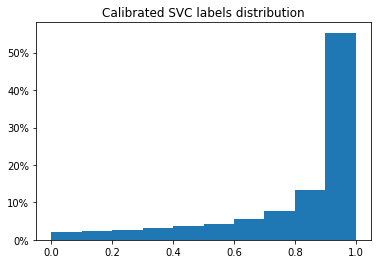

In [12]:
data = checked_review['real_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("Calibrated SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

Finally, we can save the new dataset without the ```text``` column,
in order to save space and computation time.  

In [17]:
checked_review.drop(columns=['text'], inplace=True)
checked_review.to_pickle('../dataset/checked_review.pickle')

Check that everything has worked properly. 

In [18]:
final_review = _pd.read_pickle('../dataset/checked_review.pickle')
print(final_review.columns)
final_review.head()

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,2018-01-09 20:56:38,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404


In [ ]:
_del_all()

## 3. Historical features

Following [this paper](https://www.semanticscholar.org/paper/Restaurant-Recommendation-System-Gandhe/093cecc3e53f2ba4c0c466ad3d8294ba64962050),
we add some historical features to our dataset:
1. user-level features:
    <br>1.1. average of the ratings given by a certain user,
    <br>1.2. number of reviews written by a certain user,
2. business-level features:
    <br>2.1. average of the ratings given to a certain restaurant,
    <br>2.2. number of reviews written about a certain restaurant,
3. user-business features:
    <br>3.1. average rating given by a certain user to each category,
    <br>3.2. average of the ratings given by a certain user to the categories of a certain restaurant.

Before proceeding with the computation of the new features, we have to split the dataset in three parts:
1. <i>Test set</i>, from the last day considered in the dataset, to the previous `M` months;
2. <i>Training set</i>, from the day before the beginning of the test set, up to `N` months before;
3. <i>History</i>, the remaining part of the dataset, used to compute historical features.

For the moment, we pick `m=2` and `n=9`, so the test set goes from 10/1/2018 to 11/30/2018,
the training set goes from 1/1/2018 to 9/30/2018, the history contains the remaining data,
from 10/12/2004 to 12/31/2017.

In [7]:
review_all = _pd.read_pickle("../dataset/checked_review.pickle")
review_test = review_all[review_all['date']>=_np.datetime64('2018-10-01')]
review_train = review_all[(review_all['date']>=_np.datetime64('2018-01-01')) & (review_all['date']<_np.datetime64('2018-10-01'))]
review_hist = review_all[review_all['date']<_np.datetime64('2018-01-01')]

review_test.to_pickle('../dataset/m2_n9/review_test.pickle')
review_train.to_pickle('../dataset/m2_n9/review_train.pickle')
review_hist.to_pickle('../dataset/m2_n9/review_hist.pickle')

In [9]:
tips_all = _pd.read_pickle("../dataset/all_tips.pickle")
tips_test = tips_all[tips_all['tips_date']>=_np.datetime64('2018-10-01')]
tips_train = tips_all[(tips_all['tips_date']>=_np.datetime64('2018-01-01')) & (tips_all['tips_date']<_np.datetime64('2018-10-01'))]
tips_hist = tips_all[tips_all['tips_date']<_np.datetime64('2018-01-01')]

tips_test.to_pickle('../dataset/m2_n9/tips_test.pickle')
tips_train.to_pickle('../dataset/m2_n9/tips_train.pickle')
tips_hist.to_pickle('../dataset/m2_n9/tips_hist.pickle')

In [18]:
_del_all()

### User-level features

In [3]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
users = _pd.read_pickle("../dataset/all_users.pickle")

In [8]:
avg_stars = review_hist['stars'].mean()

users = users.assign(average_stars=avg_stars)
users = users.assign(num_reviews=0)
users = users.assign(average_stars_bin=avg_stars)
users = users.assign(num_reviews_bin=0)
users = users.assign(average_stars_real=avg_stars)
users = users.assign(num_reviews_real=0)
users = users.set_index('user_id')
users.head()

,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
user_id,,,,,,,,,,,,,,,
l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.703313,2013-10-08,95,3,5,84,25,17,2374,0,3.703313,0,3.703313,0
4XChL029mKr5hydo79Ljxg,Jenna,3.703313,2013-02-21,33,0,4,48,16,22,27646,0,3.703313,0,3.703313,0
bc8C_eETBWL0olvFSJJd0w,David,3.703313,2013-10-04,16,0,0,28,10,8,358,0,3.703313,0,3.703313,0
dD0gZpBctWGdWo9WlGuhlA,Angela,3.703313,2014-05-22,17,0,5,30,14,4,12598,0,3.703313,0,3.703313,0
MM4RJAeH6yuaN8oZDSt0RA,Nancy,3.703313,2013-10-23,361,4,39,1114,665,279,5542,0,3.703313,0,3.703313,0


In [3]:
def _f(grouped):
    d = {}
    
    d['num'] = grouped['stars'].size
    d['stars'] = grouped['stars'].mean()
    
    non_fake = _np.ma.masked_where(grouped['bin_truth_score']<0, grouped['stars']).compressed()
    d['num_bin'] = non_fake.size
    d['stars_bin'] = non_fake.mean()
    
    d['num_real'] = grouped['real_truth_score'].sum()
    d['stars_real'] = _np.average(grouped['stars'], weights=grouped['real_truth_score'])
    
    return _pd.Series(d, index=['num', 'stars', 'num_bin', 'stars_bin', 'num_real', 'stars_real'])

In [ ]:
grouped_reviews = review_hist.groupby('user_id').apply(_f)
grouped_reviews.head()

In [18]:
import time
import random
import statistics

current_milli_time = lambda: int(round(time.time() * 1000))

def get_time(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test"]] = x
    t0 = current_milli_time()
    return t0-t

def get_time_mul(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    y = random.randrange(1000)
    z = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test", "ciao", "prova"]] = [x, y, z]
    t0 = current_milli_time()
    return t0-t

def test():
    df = users.copy()
    df['test'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def test_mul():
    df = users.copy()
    df['test'] = -1
    df['ciao'] = -1
    df['prova'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def tot_time(ops, x, k):
    time_millis = ops * k * x
    hours = time_millis/1000/60/60
    return hours

tot = len(grouped_reviews)
x = test()
print("hours:", tot_time(tot, x, 6))
x = test_mul()
print("hours mul:", tot_time(tot, x, 1))

hours: 53.065662455
hours mul: 8.774814544166667


In [9]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    users.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 954447
row 1000/954447 - 0.10477271131870078%
row 2000/954447 - 0.20954542263740156%
row 3000/954447 - 0.31431813395610236%
row 4000/954447 - 0.4190908452748031%
row 5000/954447 - 0.5238635565935038%
row 6000/954447 - 0.6286362679122047%
row 7000/954447 - 0.7334089792309054%
row 8000/954447 - 0.8381816905496062%
row 9000/954447 - 0.942954401868307%
row 10000/954447 - 1.0477271131870076%
row 11000/954447 - 1.1524998245057085%
row 12000/954447 - 1.2572725358244095%
row 13000/954447 - 1.3620452471431101%
row 14000/954447 - 1.4668179584618108%
row 15000/954447 - 1.5715906697805118%
row 16000/954447 - 1.6763633810992125%
row 17000/954447 - 1.7811360924179132%
row 18000/954447 - 1.885908803736614%
row 19000/954447 - 1.9906815150553148%
row 20000/954447 - 2.0954542263740152%
row 21000/954447 - 2.2002269376927166%
row 22000/954447 - 2.304999649011417%
row 23000/954447 - 2.409772360330118%
row 24000/954447 - 2.514545071648819%
row 25000/954447 - 2.6193177829675194%
row 26000/954447 - 2.724

In [10]:
users = users.reset_index()
users.to_pickle('../dataset/m2_n9/users.pickle')
_del_all()

### Business-level features

In [4]:
restaurants = _pd.read_pickle("../dataset/restaurants.pickle")
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
avg_stars = review_hist['stars'].mean()

In [5]:
restaurants = restaurants.assign(average_stars=avg_stars)
restaurants = restaurants.assign(num_reviews=0)
restaurants = restaurants.assign(average_stars_bin=avg_stars)
restaurants = restaurants.assign(num_reviews_bin=0)
restaurants = restaurants.assign(average_stars_real=avg_stars)
restaurants = restaurants.assign(num_reviews_real=0)
restaurants = restaurants.set_index('business_id')
restaurants.head()

,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,BusinessAcceptsCreditCards,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
business_id,,,,,,,,,,,,,,,,,,,,,
QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,NaN,...,00:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,True,...,21:30:00,22:00:00,22:00:00,21:00:00,3.703313,0,3.703313,0,3.703313,0
1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,True,...,01:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,True,...,00:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,True,...,NaT,NaT,NaT,NaT,3.703313,0,3.703313,0,3.703313,0


In [6]:
grouped_reviews = review_hist.groupby('business_id').apply(_f)
grouped_reviews.head()

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,num,stars,num_bin,stars_bin,num_real,stars_real
business_id,,,,,,
--1UhMGODdWsrMastO9DZw,22.0,4.227273,14.0,4.214286,16.978214,4.267477
--6MefnULPED_I942VcFNA,38.0,3.157895,32.0,3.218750,33.948759,3.218815
--9e1ONYQuAa-CB_Rrw7Tw,1504.0,4.107048,1216.0,4.088816,1205.738732,4.092415
--DaPTJW3-tB1vP-PfdTEg,40.0,3.650000,33.0,3.575758,34.780500,3.642790
--FBCX-N37CMYDfs790Bnw,122.0,3.737705,90.0,3.611111,93.369750,3.646290


In [7]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    restaurants.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 56850
row 1000/56850 - 1.759014951627089%
row 2000/56850 - 3.518029903254178%
row 3000/56850 - 5.277044854881266%
row 4000/56850 - 7.036059806508356%
row 5000/56850 - 8.795074758135444%
row 6000/56850 - 10.554089709762533%
row 7000/56850 - 12.313104661389621%
row 8000/56850 - 14.072119613016712%
row 9000/56850 - 15.8311345646438%
row 10000/56850 - 17.590149516270888%
row 11000/56850 - 19.349164467897978%
row 12000/56850 - 21.108179419525065%
row 13000/56850 - 22.867194371152156%
row 14000/56850 - 24.626209322779243%
row 15000/56850 - 26.385224274406333%
row 16000/56850 - 28.144239226033424%
row 17000/56850 - 29.90325417766051%
row 18000/56850 - 31.6622691292876%
row 19000/56850 - 33.42128408091469%
row 20000/56850 - 35.180299032541775%
row 21000/56850 - 36.93931398416886%
row 22000/56850 - 38.698328935795956%
row 23000/56850 - 40.45734388742304%
row 24000/56850 - 42.21635883905013%
row 25000/56850 - 43.97537379067722%
row 26000/56850 - 45.73438874230431%
row 27000/56850 - 47.49340

In [8]:
restaurants = restaurants.reset_index()
restaurants.to_pickle('../dataset/m2_n9/restaurants.pickle')
_del_all()


### User - Business level features

In [58]:
users =  _pd.read_pickle('../dataset/m2_n9/users.pickle')
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,2.0,3.000000,2.0,3.017247,1.957334
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,12.0,3.777778,9.0,3.626019,9.280533
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,13.0,3.500000,12.0,3.326528,10.350275
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,1.0,NaN,0.0,5.000000,0.329341
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,5.0,4.400000,5.0,4.378799,4.720870


In [65]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants.head(30)

,business_id,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,...,00:00:00,01:00:00,01:00:00,00:00:00,2.726496,117.0,2.718750,96.0,2.730197,95.873087
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,...,21:30:00,22:00:00,22:00:00,21:00:00,4.063291,158.0,4.094203,138.0,4.067541,139.112078
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,...,01:00:00,01:00:00,01:00:00,00:00:00,3.125000,16.0,2.769231,13.0,2.847327,12.604125
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,...,00:00:00,01:00:00,01:00:00,00:00:00,4.230769,13.0,4.166667,12.0,4.142021,10.965903
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,...,NaT,NaT,NaT,NaT,4.097561,41.0,4.212121,33.0,4.167159,33.655622
5,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,"Center Core - Food Court, Fl 3, Pittsburgh Int...",Others,15231,40.496177,-80.246011,35,4.0,False,...,NaT,NaT,NaT,NaT,4.000000,12.0,3.666667,9.0,3.829517,9.354469
6,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Mexican,89156,36.195615,-115.040529,184,4.5,False,...,21:00:00,21:00:00,21:00:00,20:00:00,4.275000,160.0,4.319672,122.0,4.304661,127.316728
7,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Others,M6J 1J5,43.642889,-79.425429,57,3.0,NaN,...,21:00:00,21:00:00,21:00:00,21:00:00,3.150943,53.0,3.111111,45.0,3.143251,46.734504
8,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Others,M6H 1M4,43.660494,-79.432099,29,3.5,False,...,18:00:00,02:00:00,02:00:00,15:00:00,3.379310,29.0,3.444444,27.0,3.406472,25.976381
9,BvYU3jvGd0TJ7IyZdfiN2Q,Manzetti's Tavern,6401 Morrison Blvd,"Italian, American",28211,35.156338,-80.831878,16,3.5,False,...,23:00:00,23:00:00,23:00:00,22:00:00,3.555556,18.0,3.666667,15.0,3.608269,15.543350


In [41]:
restaurants.columns

Index(['business_id', 'name', 'address', 'cuisine', 'postal_code', 'latitude',
       'longitude', 'review_count', 'stars', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'RestaurantsDelivery',
       'RestaurantsReservations', 'WiFi', 'Alcohol', 'categories', 'city',
       'Monday_Open', 'Tuesday_Open', 'Wednesday_Open', 'Thursday_Open',
       'Friday_Open', 'Saturday_Open', 'Sunday_Open', 'Monday_Close',
       'Tuesday_Close', 'Wednesday_Close', 'Thursday_Close', 'Friday_Close',
       'Saturday_Close', 'Sunday_Close', 'average_stars', 'num_reviews',
       'average_stars_bin', 'num_reviews_bin', 'average_stars_real',
       'num_reviews_real'],
      dtype='object')

In [42]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
review_hist.head()

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/m2_n9/review_hist.pickle'

In [60]:
categories = ', '.join(list(restaurants['categories'].unique()))
categories = categories.split(', ')
print(len(categories))

cat = []
for h in categories:
    if h not in cat:
        cat.append(h)
        
print(len(cat))

cuisines = ', '.join(list(restaurants['cuisine'].unique()))
cuisines = cuisines.split(', ')
print(len(cuisines))

cuisines_unique = []
for cuisine in cuisines:
    if not cuisine in cuisines_unique:
        cuisines_unique.append(cuisine)
        
print("Number of cuisines: {0}".format(len(cuisines_unique)))
print(cuisines_unique)

173884
761
249
Number of cuisines: 10
['Chinese', 'Japanese', 'Mexican', 'Italian', 'Others', 'American', 'Korean', 'Mediterranean', 'Thai', 'Asian Fusion']


In [63]:
users = users.assign(av_rat_chinese_cuisine = 0, av_rat_japanese_cuisine = 0, av_rat_mexican_cuisine = 0, 
                     av_rat_italian_cuisine = 0, av_rat_others_cuisine = 0, av_rat_american_cuisine = 0, 
                     av_rat_korean_cuisine = 0, av_rat_mediterranean_cuisine = 0, av_rat_thai_cuisine = 0, 
                     av_rat_asianfusion_cuisine = 0)

users = users.assign(av_rat_chinese_cuisine_bin = 0, av_rat_japanese_cuisine_bin = 0, av_rat_mexican_cuisine_bin = 0, 
                     av_rat_italian_cuisine_bin = 0, av_rat_others_cuisine_bin = 0, av_rat_american_cuisine_bin = 0, 
                     av_rat_korean_cuisine_bin = 0, av_rat_mediterranean_cuisine_bin = 0, av_rat_thai_cuisine_bin = 0, 
                     av_rat_asianfusion_cuisine_bin = 0)

users = users.assign(av_rat_chinese_cuisine_real = 0, av_rat_japanese_cuisine_real = 0, av_rat_mexican_cuisine_real = 0, 
                     av_rat_italian_cuisine_real = 0, av_rat_others_cuisine_real = 0, av_rat_american_cuisine_real = 0, 
                     av_rat_korean_cuisine_real = 0, av_rat_mediterranean_cuisine_real = 0, av_rat_thai_cuisine_real = 0, 
                     av_rat_asianfusion_cuisine_real = 0)

users = users.set_index('user_id')

In [64]:
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,...,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,...,0,0,0,0,0,0,0,0,0,0
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,...,0,0,0,0,0,0,0,0,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,...,0,0,0,0,0,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,...,0,0,0,0,0,0,0,0,0,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def each_cuisine_ratings(grouped):
    d = {}
    for cuisine in cuisines_unique:
        cuisine_av = cuisine + "_av"
        cuisine_records = _np.ma.masked_where((grouped['business_id'] != restaurants['business_id']) & (!restaurants.cuisine.str.contains(cuisine)), grouped['stars']).compressed()
        d[cuisine_av] = cuisine_records.mean()
        
    for cuisine in cuisines_unique:
        cuisine_av_bin = cuisine + "_av_bin"
        non_fake = _np.ma.masked_where(grouped['bin_truth_score'] < 0, grouped['stars']).compressed()
        cuisine_records = _np.ma.masked_where((non_fake['business_id'] != restaurants['business_id']) & (!restaurants.cuisine.str.contains(cuisine)), non_fake['stars']).compressed()
        d[cuisine_av_bin] = cuisine_records.mean()
    
    for cuisine in cuisines_unique:
        cuisine_av_real = cuisine + "_av_real"
        cuisine_records = _np.ma.masked_where((grouped['business_id'] != restaurants['business_id']) & (!restaurants.cuisine.str.contains(cuisine)), grouped['stars']).compressed()
        cuisine_truth_score = _np.ma.masked_where((grouped['business_id'] != restaurants['business_id']) & (!restaurants.cuisine.str.contains(cuisine)), grouped['real_truth_score']).compressed()
        d[cuisine_av_real] = _np.average(cousine_records, weights = cuisine_truth_score)
    

In [ ]:
grouped_reviews = review_hist.groupby('user_id').apply(each_cuisine_ratings)
grouped_reviews.head()

In [ ]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    vals = []
    
    for cuisine in cuisines_unique:
        cuisine_av = cuisine + "_av"
        vals.append(row[cuisine_av])
        
    for cuisine in cuisines_unique:
        cuisine_av_bin = cuisine + "_av_bin"
        vals.append(row[cuisine_av_bin])
        
    for cuisine in cuisines_unique:
        cuisine_av_real = cuisine + "_av_real"
        vals.append(row[cuisine_av_real])
        
        
    cols = ['av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin'
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']
    
    
    users.loc[uid, cols] = vals
    
    count += 1
    if (count % 1000) == 0:
        percent = (count / tot) * 100
        print("row {}/{} - {}%".format(count, tot, percent))